# T-Test as general linear model


In order to go Bayesian, we first formulate our t-test as a GLM.

Assuming equal variances, we can write

$$ Y = \alpha + \beta X + \epsilon$$
$$ \epsilon \sim N(0, \sigma^2) $$

where $X$ indicates group membership.

It is not necessary to assume equal variances, we could just as well let each group have their own.

An alternative way of writing the GLM:

$$ Y \sim N(\alpha + \beta X, \sigma^2) $$

Using R's formula notation, we can write this as

```r
fit_ols <- lm(IQ ~ Group,
              data = TwoGroupIQ)
```

(The outcome `IQ` is modeled as a function of `Group`)


$$ IQ = Placebo + \beta \cdot SmartDrug  + \epsilon$$

$$\epsilon \sim N(0, \sigma^2) $$


The $\beta$ parameter therefore represents the difference between groups.


In [7]:
library(tidyverse)
smart = tibble(IQ = c(101,100,102,104,102,97,105,105,98,101,100,123,105,103,
                      100,95,102,106,109,102,82,102,100,102,102,101,102,102,
                      103,103,97,97,103,101,97,104,96,103,124,101,101,100,
                      101,101,104,100,101),
               Group = "SmartDrug")

placebo = tibble(IQ = c(99,101,100,101,102,100,97,101,104,101,102,102,100,105,
                        88,101,100,104,100,100,100,101,102,103,97,101,101,100,101,
                        99,101,100,100,101,100,99,101,100,102,99,100,99),
                 Group = "Placebo")

TwoGroupIQ <- bind_rows(smart, placebo)  %>%
    mutate(Group = fct_relevel(as.factor(Group), "Placebo"))

In [10]:
fit_ols <- lm(IQ ~ Group,
              data = TwoGroupIQ)
summary(fit_ols)


Call:
lm(formula = IQ ~ Group, data = TwoGroupIQ)

Residuals:
     Min       1Q   Median       3Q      Max 
-19.9149  -0.9149   0.0851   1.0851  22.0851 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)    100.3571     0.7263 138.184   <2e-16 ***
GroupSmartDrug   1.5578     0.9994   1.559    0.123    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.707 on 87 degrees of freedom
Multiple R-squared:  0.02717,	Adjusted R-squared:  0.01599 
F-statistic:  2.43 on 1 and 87 DF,  p-value: 0.1227


## Generative model

For a Bayesian model, we need prior distributions on all parameters.


The outcome $y$ can be modelled as a normally distributed random variable. The normal distribution has two parameters:

- $\mu$: this is predicted using a linear model
- $\sigma$: this needs a prior ($\sigma > 0$)


### Linear regression as a probabilistic model

- The graphical model shows the data-generating process (dependencies among the random variables).

-  $\alpha$ is our expectation for the placebo group, $\beta$ is our expectation for the difference in means. $\sigma$ is the variance of the outcome.


![](figures/graphical-model-1.png)

## Software
Probabilistic programming languages:

- Winbugs / Jags

- [Stan](https://mc-stan.org): Turing complete probabilistic programming language

- [PyMC3](https://docs.pymc.io): Probabilistic programming in Python

- [Turing](http://turing.ml): Probabilistic programming language with an intuitive modelling interface.

<br>
R interface / GUI:

- [brms](https://github.com/paul-buerkner/brms): R package for Bayesian generalized multivariate non-linear multilevel models using Stan

- [rstanarm](http://mc-stan.org/rstanarm/): less flexible than `brms`, but models are pre-compiled

- [JASP](https://jasp-stats.org): GUI for simple models (frequentist and Bayesian)


## Inference using Stan

We can translate the graphical model into a `Stan` program (this is what `brms` does).

- shaded nodes are observed (conditioned upon)

- $\mu$ is a deterministic node (double border). In the `Stan` program, we omit this

- $y$ depends on $\mu$, $\sigma$

``` C++
data {
  int<lower=0> N;
  vector[N] x;
  vector[N] y;
}
parameters {
  real alpha;
  real beta;
  real<lower=0> sigma;
}
model {
  sigma ~ cauchy(0, 2.5);
  alpha ~ normal(100, 15);
  beta ~ normal(0, 10);
  y ~ normal(alpha + beta * x, sigma);
}
```

![](figures/graphical-model-1.png)

## brms: equal variance model

- Whilst this is very powerful, and for simple models also pretty easy, it gets tedious for complex models.

- Fortunately, `brms` simplifies this process, by allowing us to specify a model using `lme4` style formula notation.

- `brms` then generates `Stan` code, and provides several convience functions for accessing the marginal posterior distributions.

- In this model, we let `brms` set priors.

- `brms` allows specification of non-linear models. A simple linear regression looks like this


In [13]:
suppressWarnings(library(brms))
fit_eqvar <- brm(IQ ~ Group,
                 data = TwoGroupIQ,
                 file = here::here("models/fit_iq-eqvar"))


summary(fit_eqvar)

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: IQ ~ Group 
   Data: TwoGroupIQ (Number of observations: 89) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup samples = 4000

Population-Level Effects: 
               Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept        100.35      0.72    98.92   101.74 1.00     3866     2623
GroupSmartDrug     1.57      0.99    -0.37     3.51 1.00     3789     2979

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma     4.76      0.36     4.13     5.53 1.00     3214     2791

Samples were drawn using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures, and Rhat is the potential
scale reduction factor on split chains (at convergence, Rhat = 1).

## Estimated parameter

Marginal posterior distribution of the regression parameter $\beta$


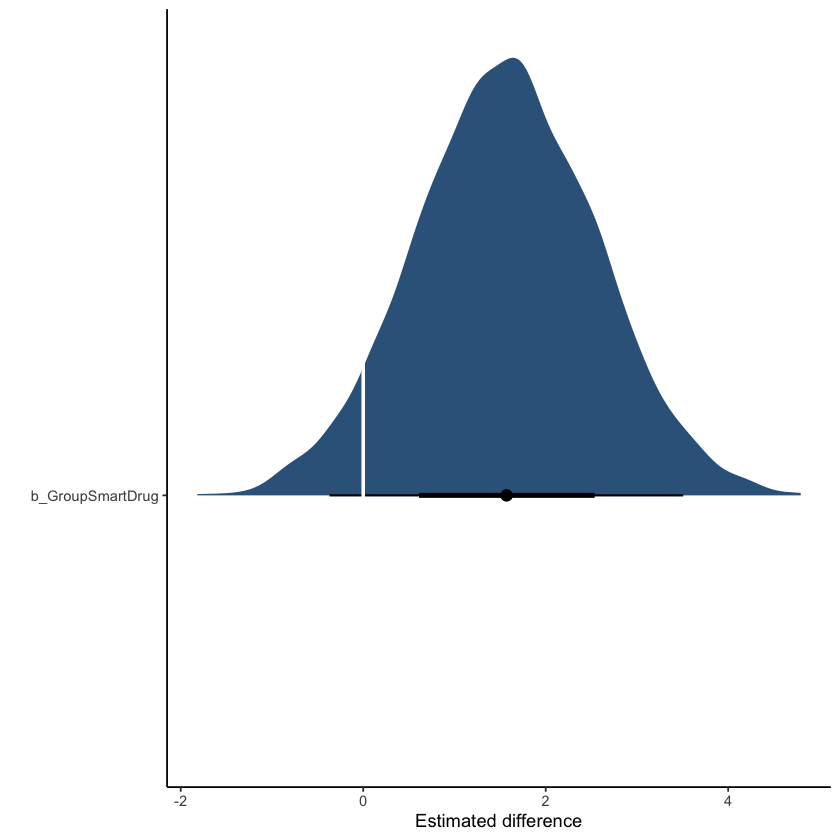

In [15]:
library(tidybayes)

fit_eqvar %>%
    gather_draws(b_GroupSmartDrug) %>%
    ggplot(aes(y = .variable, x = .value)) +
    geom_halfeyeh(fill = "Steelblue4") +
    geom_vline(xintercept = 0, color = "white", linetype = 1, size = 1) +
    ylab("") +
    xlab("Estimated difference") +
    theme_classic()

## Posterior predictions: normal model

We can plot the predicted marginal means and the predictive bands alongside the data


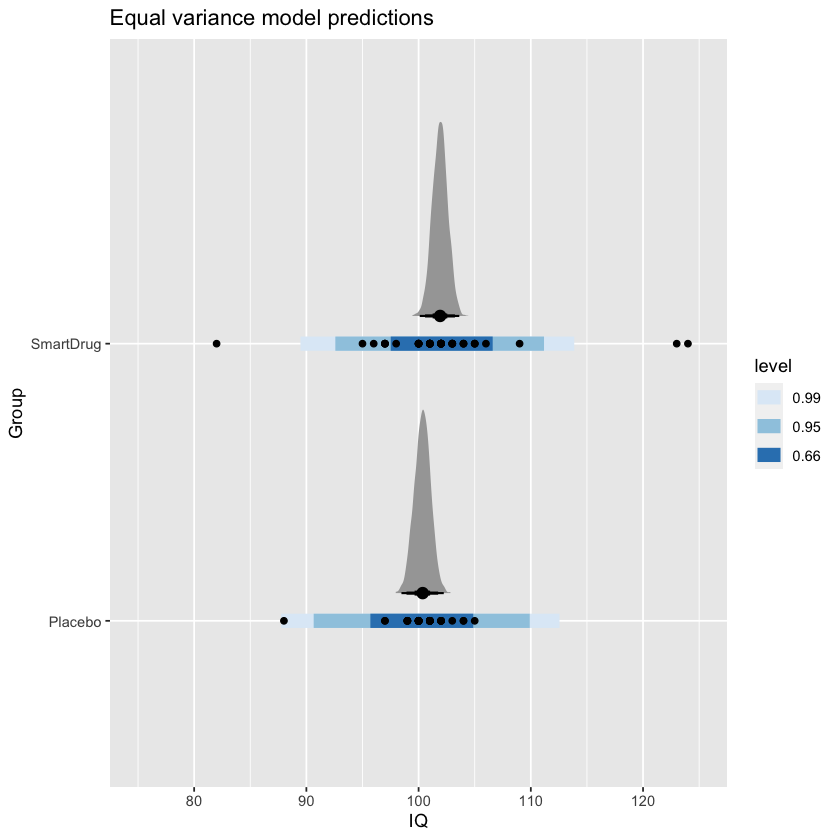

In [20]:
grid <- TwoGroupIQ %>%
    modelr::data_grid(Group)

fits_IQ <- grid %>%
    add_fitted_draws(fit_eqvar)

preds_IQ <- grid %>%
    add_predicted_draws(fit_eqvar)

TwoGroupIQ %>%
    ggplot(aes(x = IQ, y = Group)) +
    geom_halfeyeh(aes(x = .value),
                  scale = 0.7,
                  position = position_nudge(y = 0.1),
                  data = fits_IQ,
                  .width = c(.66, .95, 0.99)) +
    stat_intervalh(aes(x = .prediction),
                   data = preds_IQ,
                   .width = c(.66, .95, 0.99)) +
    scale_x_continuous(limits = c(75, 125)) +
    geom_point(data = TwoGroupIQ) +
    scale_color_brewer() +
	labs(title = "Equal variance model predictions")

## Hypothesis testing

What we have done so far is parameter estimation. In order to perform a Bayesian analogue of a significance test, we need to do model comparison.



In [ ]:
fit_null <- brm(IQ ~ 1,
                 data = TwoGroupIQ)